# Weight tracking, analysis and forecast

## Setup

In [1]:
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
print(f'Python = {sys.version}')
print(f'Numpy = {np.__version__}')
print(f'Tensorflow = {tf.__version__}')

Python = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Numpy = 1.20.3
Tensorflow = 2.5.0


In [3]:
import weightlib as wl

# Data Extraction

=> file "data_BEN.zip" contains the file "weight.csv" with all daily measurements of total mass, fat mass.

=> file "Suivi_Poids.csv" has manually-entered daily numbers for total mass and fat mass, plus nutrition data (lipid, carbs, proteines), and calories data (ingested, spent with cardio, spent with strength training)

In [4]:
ROOT = os.getcwd() + '/'
print(f'current working directory is {ROOT}')
print(f'contains :')
print(f'{os.listdir(ROOT)}')

current working directory is c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/
contains :
['.git', '.ipynb_checkpoints', 'data_BEN.zip', 'desktop.ini', 'model.png', 'pat.txt', 'polar-user-data-export.zip', 'README.md', 'Suivi_Poids.csv', 'test_methodes.xlsx', 'tmp', 'weight.ipynb', 'weightlib.py', 'weight_arima.ipynb', 'weight_rapport.ipynb', 'weight_recherche.ipynb', '__pycache__']


In [5]:
ds = wl.GetData(ROOT + 'data_BEN.zip', ROOT + 'Suivi_Poids.csv')

In [6]:
ds.extract()

Extraction fichier Zip Healthmate dans c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/tmp...
... Done


In [7]:
raw_df = ds.get_dataframe()

raw_df.set_index('date', inplace=True)

In [8]:
raw_df

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength
date,,,,,,,,,
2020-09-01,101.250,33.020,2015.0,262.0,48.0,120.0,281.0,281.0,0.0
2020-09-02,101.150,31.945,1942.0,162.0,94.0,100.0,419.0,419.0,0.0
2020-09-03,101.200,30.930,1938.0,227.0,72.0,93.0,403.0,403.0,0.0
2020-09-04,100.800,29.460,1851.0,274.0,43.0,91.0,439.0,439.0,0.0
2020-09-05,100.600,31.450,1774.0,214.0,54.0,90.0,563.0,563.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-12-17,68.665,8.680,2155.0,256.0,46.0,181.0,457.0,0.0,457.0
2021-12-18,68.030,8.178,2144.0,214.0,56.0,177.0,423.0,0.0,423.0
2021-12-19,68.750,8.596,1741.0,213.0,54.0,95.0,0.0,0.0,0.0


### Dataframe with 'engineered' features

In [9]:
df = raw_df

# créée masse_seche
df['masse_seche'] = df['masse_totale'] - df['masse_grasse']

# calories nettes
df['calories_nettes'] = df['calories_in'] - df['calories_exercice']

# body fat percentage
df['bf_perc'] = df['masse_grasse'] / df['masse_totale']


In [10]:
df['msj'] = df['masse_totale'].apply(wl.msj)
df['oxf'] = df['masse_totale'].apply(wl.oxf)
df['sch'] = df['masse_totale'].apply(wl.sch)
df['kma'] = df['masse_seche'].apply(wl.kma)

# df['base_metabolism'] = df[['msj','oxf','sch','kma']].apply(np.mean, axis=1)
df['base_metabolism'] = df['kma']  # on utilise Katch Mac Ardle pour métabolisme de base

df['rest_metabolism'] = df['base_metabolism'] * 1.10  # coefficient adapté de façon à ce que le déficit calorique soit au voisinage de zéro quand les courbes s'inversent entre sèche et bulk

df['calories_deficit'] = df['calories_in'] - df['rest_metabolism'] - df['calories_exercice']

In [11]:
df

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,calories_nettes,bf_perc,msj,oxf,sch,kma,base_metabolism,rest_metabolism,calories_deficit
date,,,,,,,,,,,,,,,,,,,
2020-09-01,101.250,33.020,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,68.230,1734.0,0.326123,1886.97750,2030.750,2034.64000,1843.7680,1843.7680,2028.14480,-294.14480
2020-09-02,101.150,31.945,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,69.205,1523.0,0.315818,1885.97850,2029.330,2033.49280,1864.8280,1864.8280,2051.31080,-528.31080
2020-09-03,101.200,30.930,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,70.270,1535.0,0.305632,1886.47800,2030.040,2034.06640,1887.8320,1887.8320,2076.61520,-541.61520
2020-09-04,100.800,29.460,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,71.340,1412.0,0.292262,1882.48200,2024.360,2029.47760,1910.9440,1910.9440,2102.03840,-690.03840
2020-09-05,100.600,31.450,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,69.150,1211.0,0.312624,1880.48400,2021.520,2027.18320,1863.6400,1863.6400,2050.00400,-839.00400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17,68.665,8.680,2155.0,256.0,46.0,181.0,457.0,0.0,457.0,59.985,1698.0,0.126411,1561.45335,1568.043,1660.82488,1665.6760,1665.6760,1832.24360,-134.24360
2021-12-18,68.030,8.178,2144.0,214.0,56.0,177.0,423.0,0.0,423.0,59.852,1721.0,0.120212,1555.10970,1559.026,1653.54016,1662.8032,1662.8032,1829.08352,-108.08352
2021-12-19,68.750,8.596,1741.0,213.0,54.0,95.0,0.0,0.0,0.0,60.154,1741.0,0.125033,1562.30250,1569.250,1661.80000,1669.3264,1669.3264,1836.25904,-95.25904


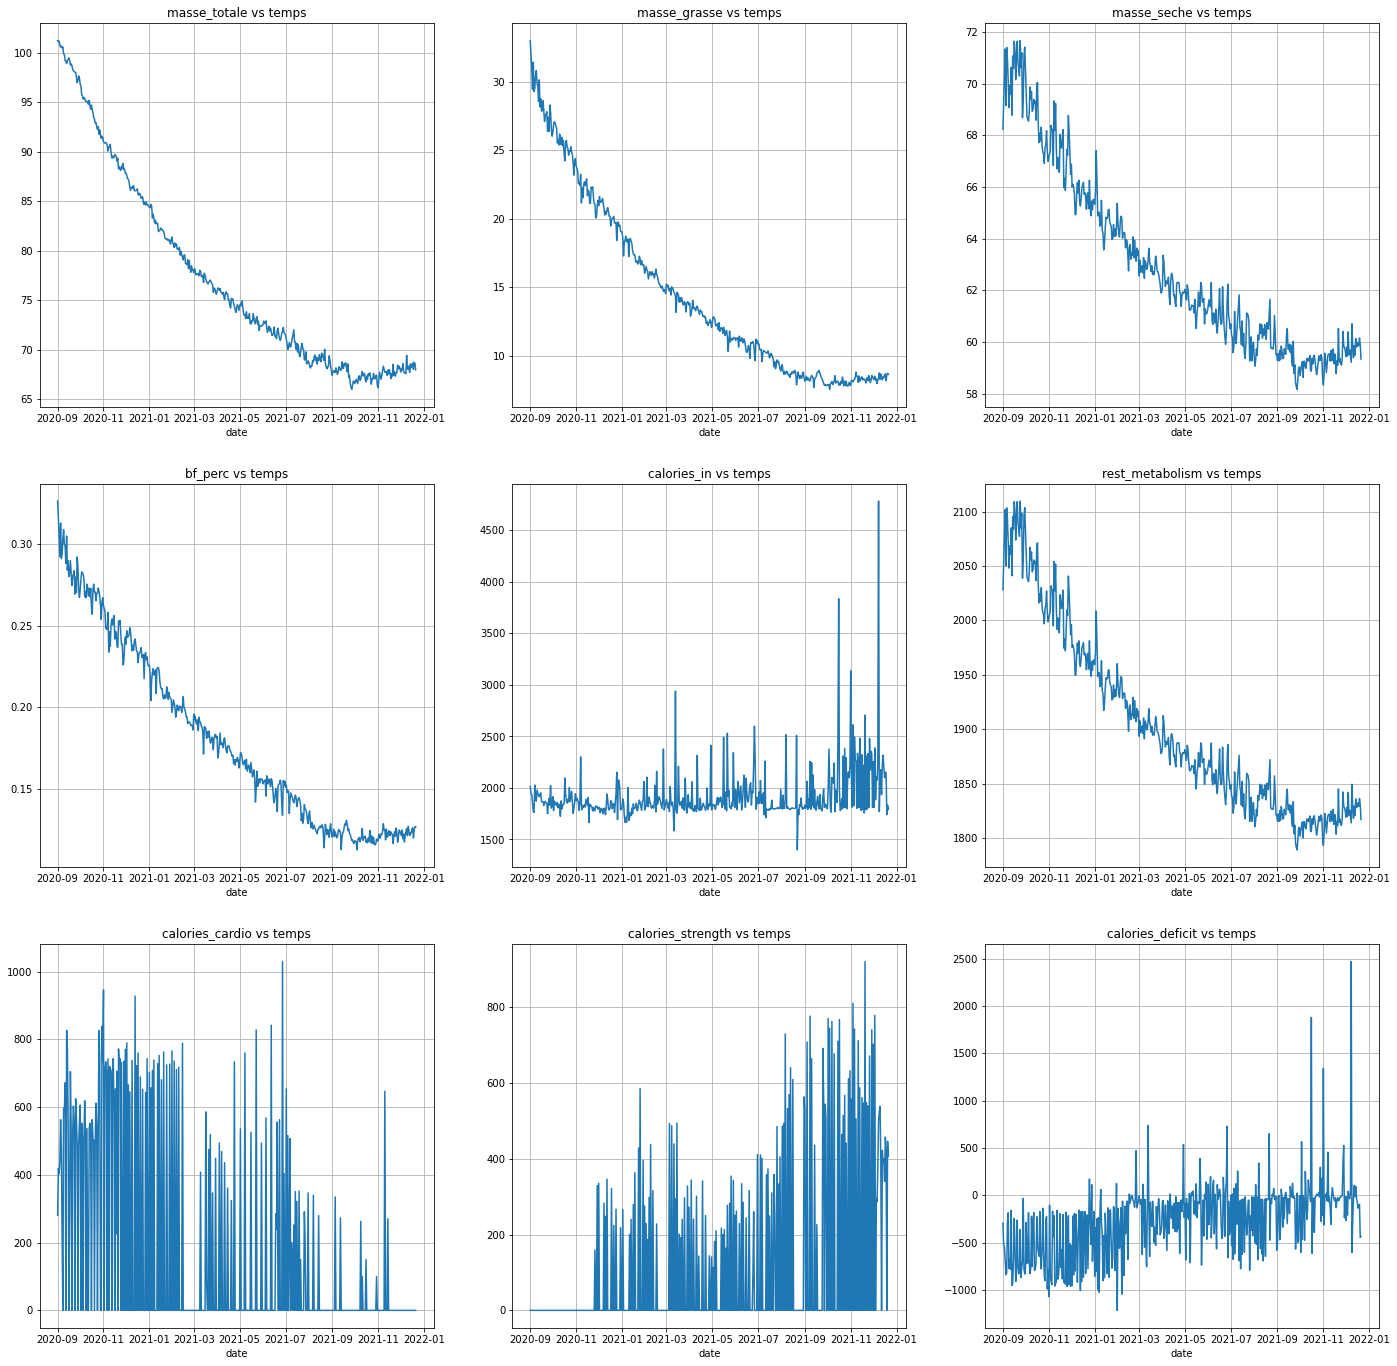

In [12]:
wl.plot_columns(df)

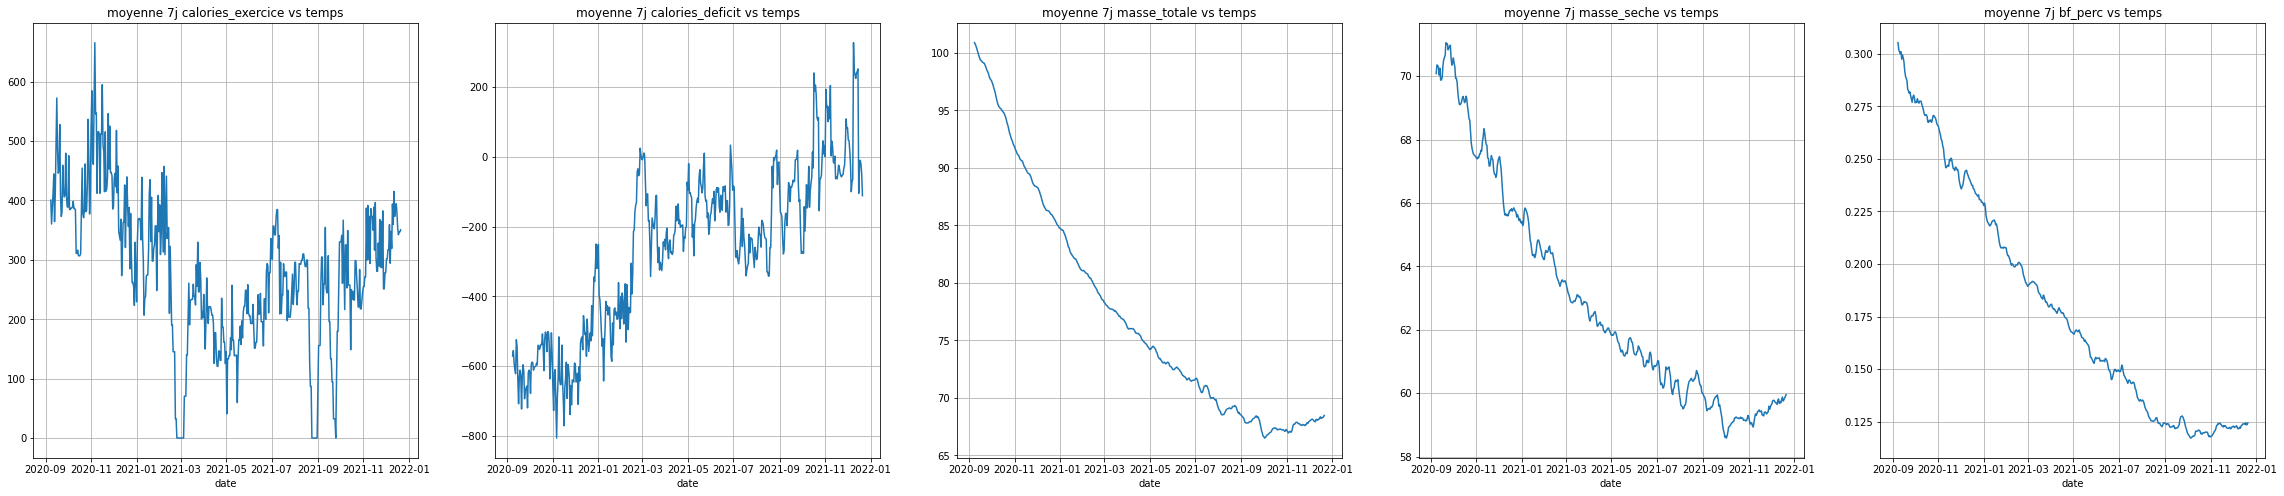

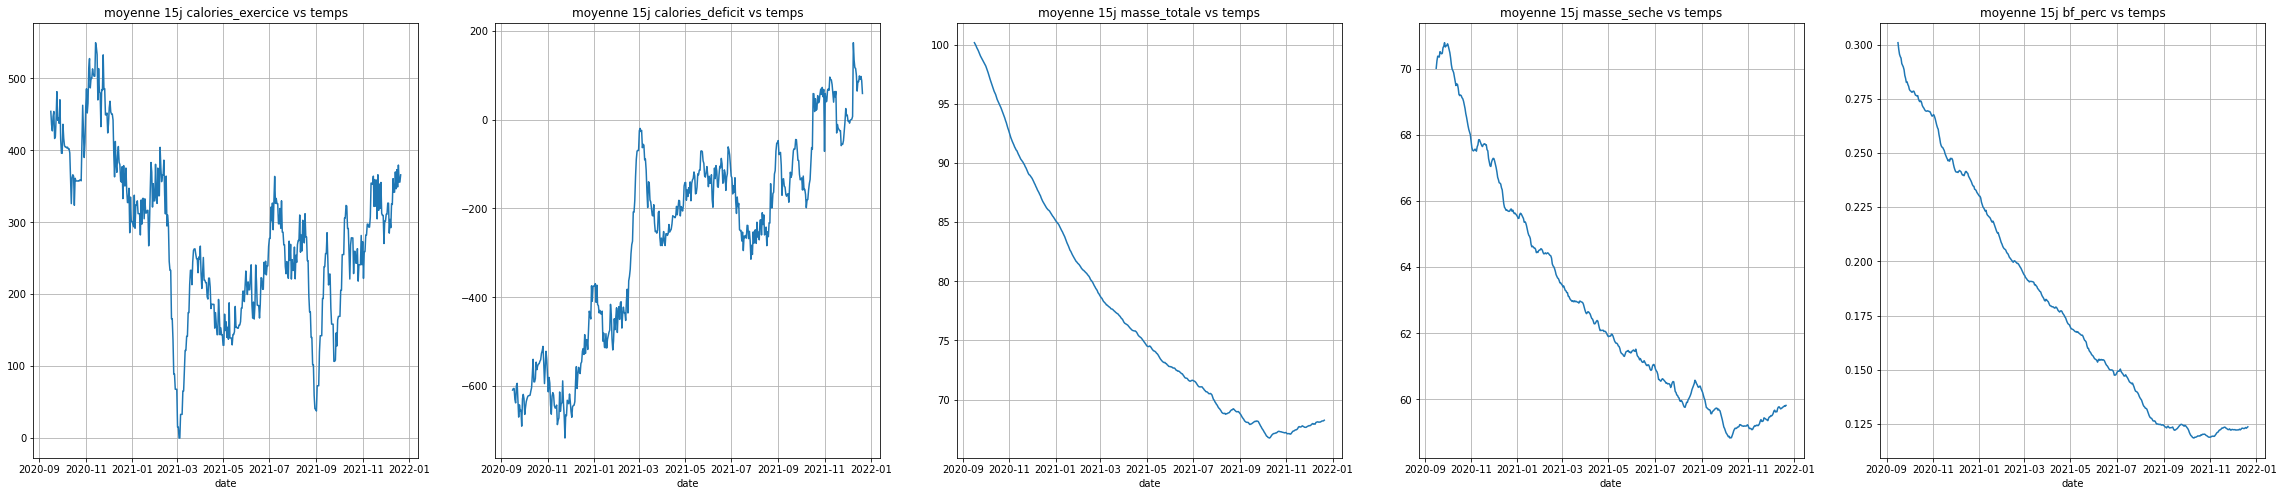

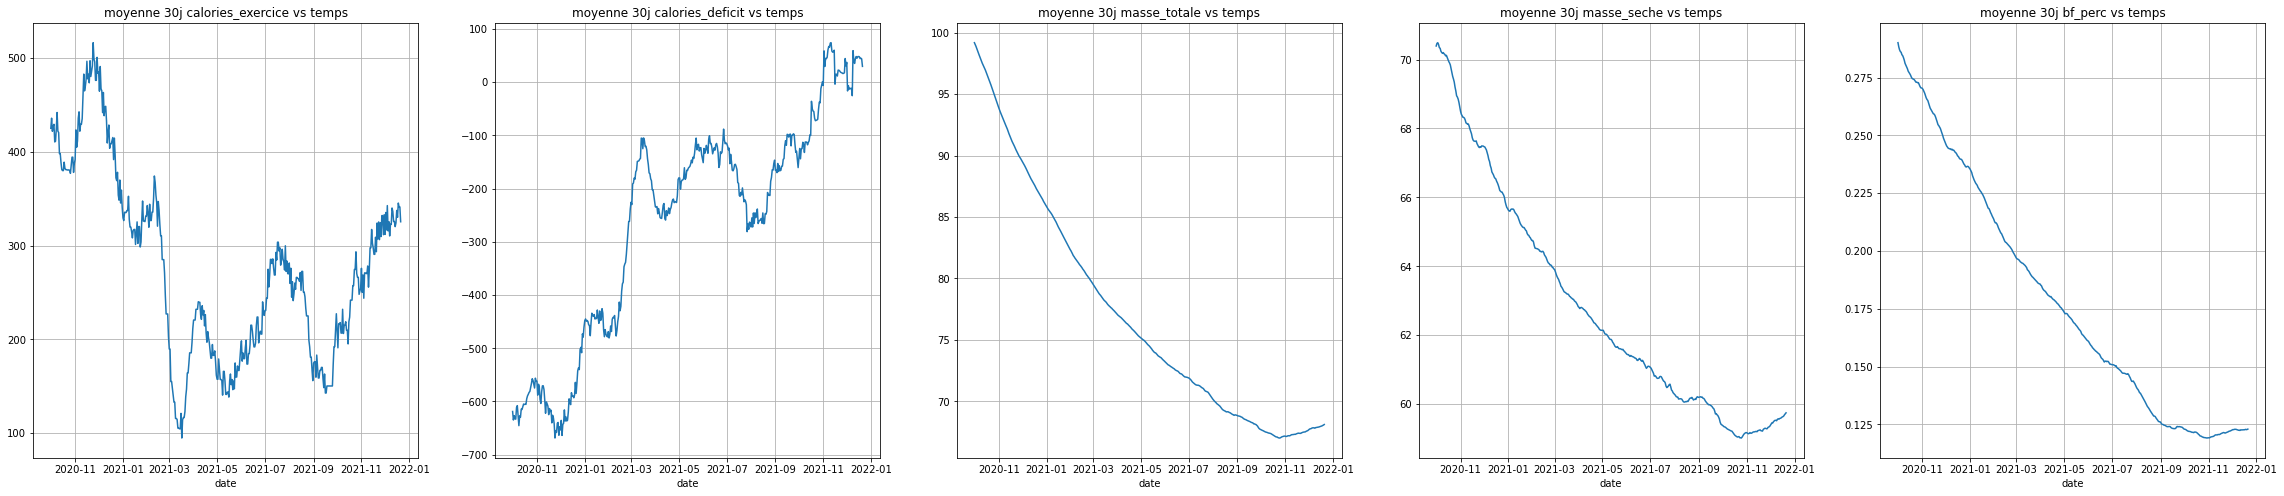

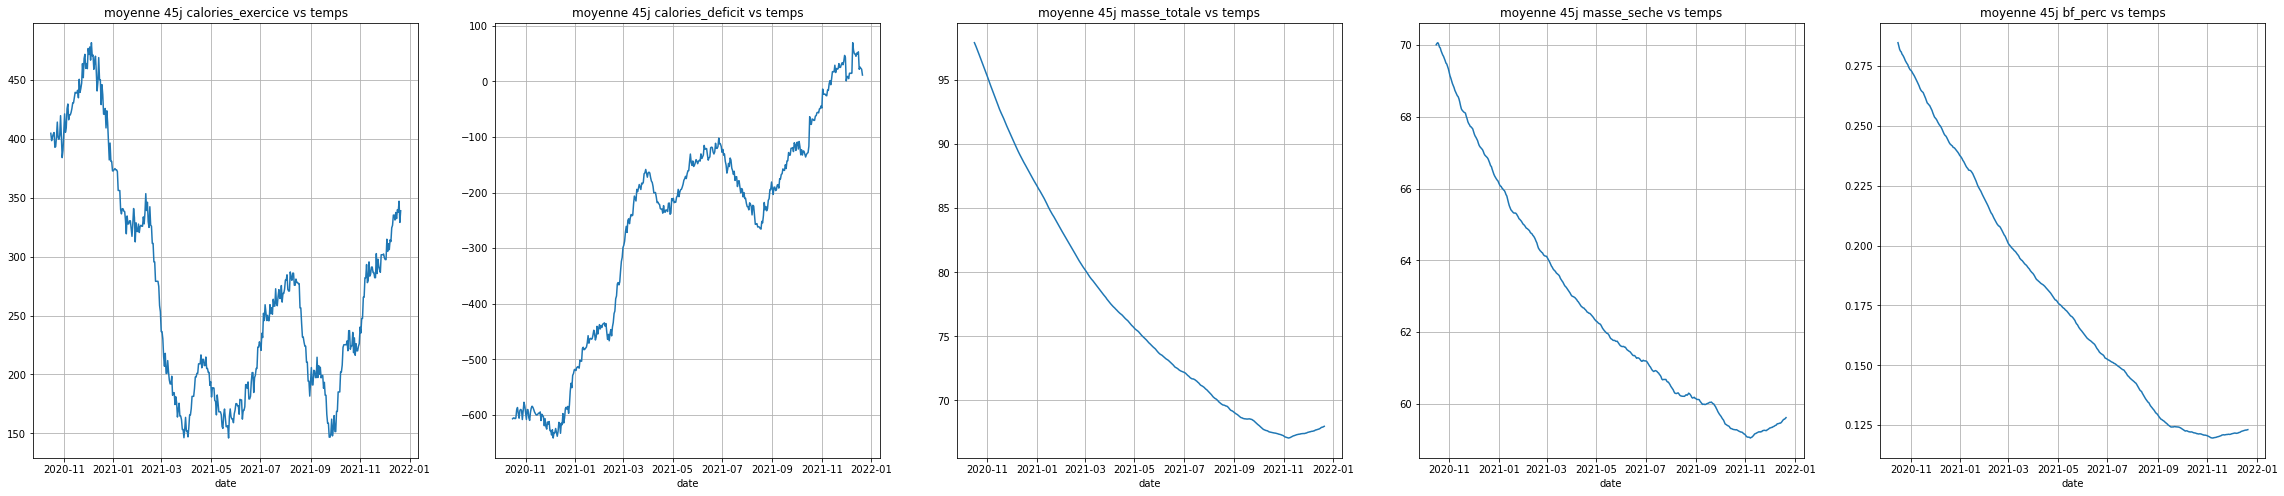

In [13]:
window_list = [7,15,30,45]

for w in window_list:
    wl.plot_moyennes(df, window=w)

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


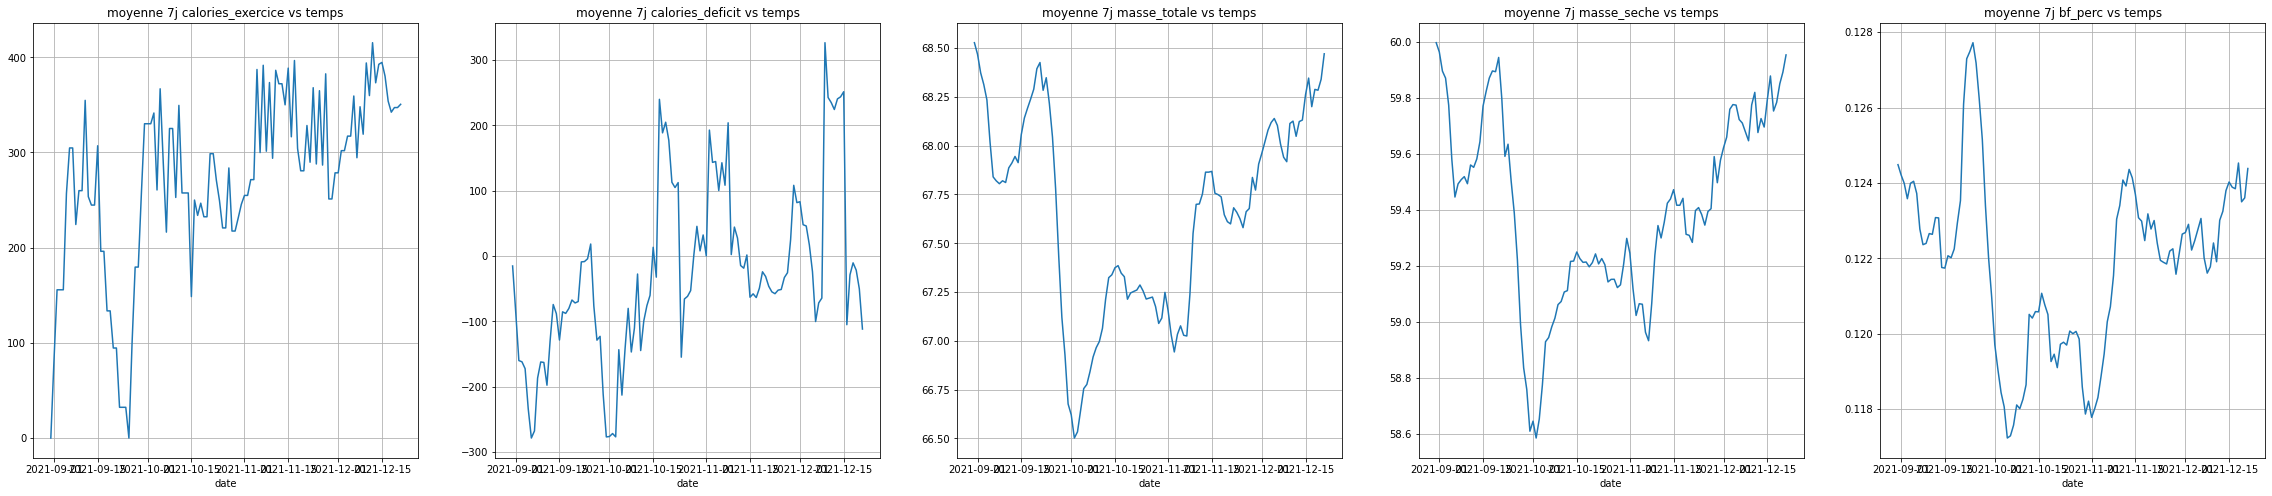

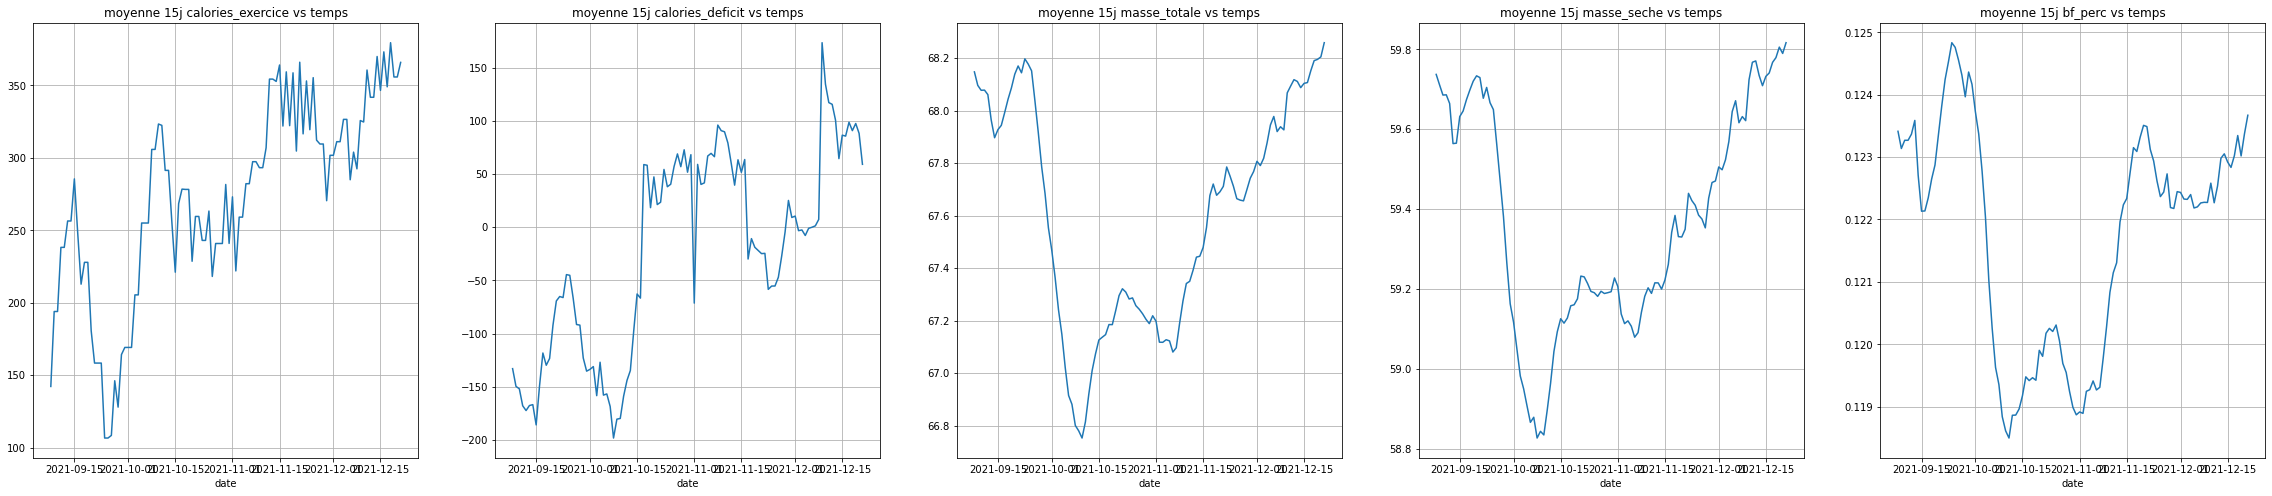

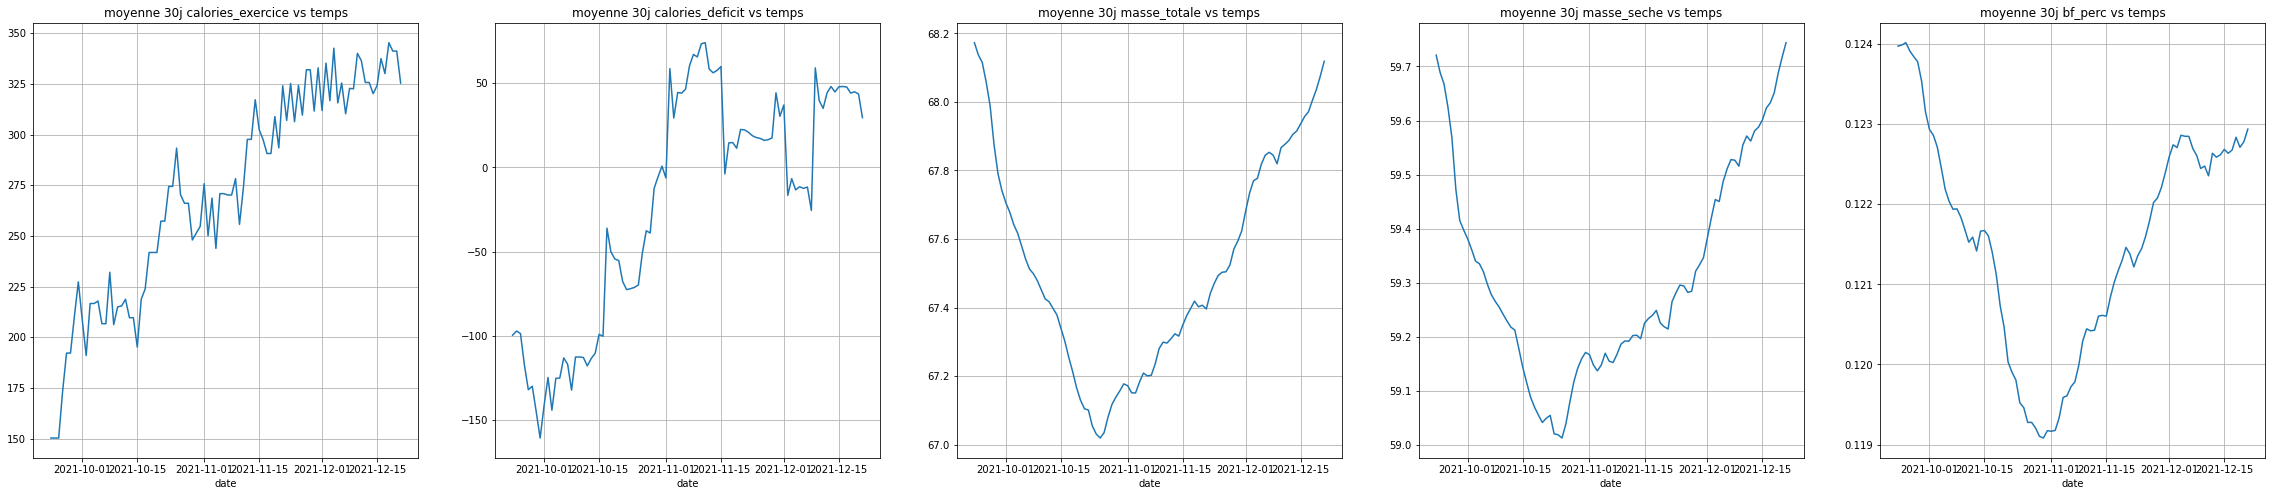

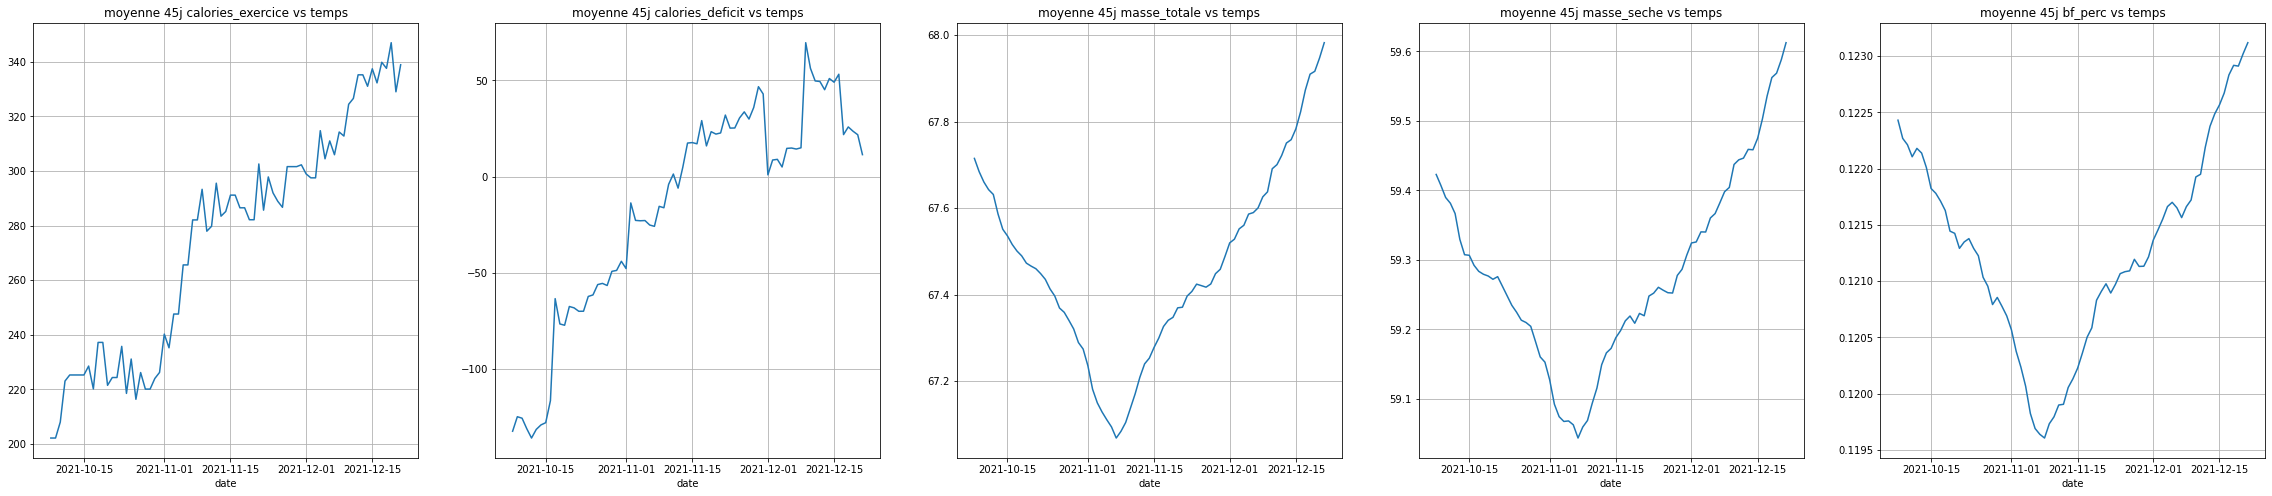

In [14]:
over_last_days = 120

start_date = datetime.date.today() - datetime.timedelta(days = over_last_days)
index_to_drop = [df.index < start_date]

df_last = df.drop(index = df.index[index_to_drop])

window_list = [7,15, 30, 45]

for w in window_list:
    wl.plot_moyennes(df=df_last, window=w)

# On distingue deux périodes :
- une période de "sèche" jusqu'à fin septembre 2021 environ
- une période de "bulk" plus ou moins clean (?) à partir d'octobre 2021

In [15]:
cut_off = datetime.date(2021,10,1)

df_seche = df[df.index < cut_off]
df_bulk = df[df.index >= cut_off]

In [16]:
df_seche

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,...,sch,kma,base_metabolism,rest_metabolism,calories_deficit,moyenne calories_exercice,moyenne calories_deficit,moyenne masse_totale,moyenne masse_seche,moyenne bf_perc
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01,101.250000,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,68.230000,...,2034.640000,1843.768000,1843.768000,2028.144800,-294.144800,NaN,NaN,NaN,NaN,NaN
2020-09-02,101.150000,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,69.205000,...,2033.492800,1864.828000,1864.828000,2051.310800,-528.310800,NaN,NaN,NaN,NaN,NaN
2020-09-03,101.200000,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,70.270000,...,2034.066400,1887.832000,1887.832000,2076.615200,-541.615200,NaN,NaN,NaN,NaN,NaN
2020-09-04,100.800000,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,71.340000,...,2029.477600,1910.944000,1910.944000,2102.038400,-690.038400,NaN,NaN,NaN,NaN,NaN
2020-09-05,100.600000,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,69.150000,...,2027.183200,1863.640000,1863.640000,2050.004000,-839.004000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,66.250000,7.985000,1990.0,167.0,63.0,168.0,566.0,0.0,566.0,58.265000,...,1633.120000,1628.524000,1628.524000,1791.376400,-367.376400,149.511111,-119.039613,68.366786,59.874469,0.124211
2021-09-27,66.000000,7.835714,1812.0,121.0,53.0,172.0,0.0,0.0,0.0,58.164286,...,1630.252000,1626.348571,1626.348571,1788.983429,23.016571,162.088889,-126.244333,68.315304,59.832580,0.124161
2021-09-28,66.433333,7.908333,1845.0,168.0,55.0,167.0,544.0,0.0,544.0,58.525000,...,1635.223200,1634.140000,1634.140000,1797.554000,-496.554000,147.866667,-110.343353,68.244415,59.780631,0.124009


In [17]:
df_seche.describe()

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,...,sch,kma,base_metabolism,rest_metabolism,calories_deficit,moyenne calories_exercice,moyenne calories_deficit,moyenne masse_totale,moyenne masse_seche,moyenne bf_perc
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,79.572731,15.884847,1872.154430,177.946835,58.810127,129.792405,277.632911,195.232911,82.400000,63.687885,...,1785.958375,1745.658311,1745.658311,1920.224142,-325.702623,274.708127,-320.637729,79.121752,63.560639,0.191683
std,9.694319,6.348998,145.471486,41.029638,14.950405,29.082369,295.954182,292.398130,164.693815,3.417248,...,111.213231,73.812555,73.812555,81.193811,343.479708,100.223849,181.448012,8.403577,2.939529,0.046509
min,66.000000,7.685000,1399.000000,43.000000,8.000000,13.000000,0.000000,0.000000,0.000000,58.164286,...,1630.252000,1626.348571,1626.348571,1788.983429,-1215.191200,146.066667,-641.409529,68.129495,59.704488,0.123645
25%,71.583333,10.690000,1799.000000,154.000000,48.000000,114.000000,0.000000,0.000000,0.000000,60.908333,...,1694.304000,1685.620000,1685.620000,1854.182000,-595.616000,188.688889,-481.389680,72.013056,61.090648,0.151660
50%,77.050000,14.260000,1831.000000,173.000000,58.000000,133.000000,220.000000,0.000000,0.000000,62.776667,...,1757.017600,1725.976000,1725.976000,1898.573600,-245.343200,251.966667,-229.255792,77.100815,62.854152,0.184726
75%,86.416667,20.616667,1890.500000,199.500000,69.500000,147.000000,544.500000,489.500000,0.000000,65.988333,...,1864.472000,1795.348000,1795.348000,1974.882800,-49.478400,345.177778,-172.181139,85.592870,65.767481,0.231508
max,101.250000,33.020000,2940.000000,334.000000,106.000000,225.000000,1041.000000,1030.000000,776.000000,71.663333,...,2034.640000,1917.928000,1917.928000,2109.720800,738.397600,481.511111,-102.019840,97.909815,70.065500,0.284743


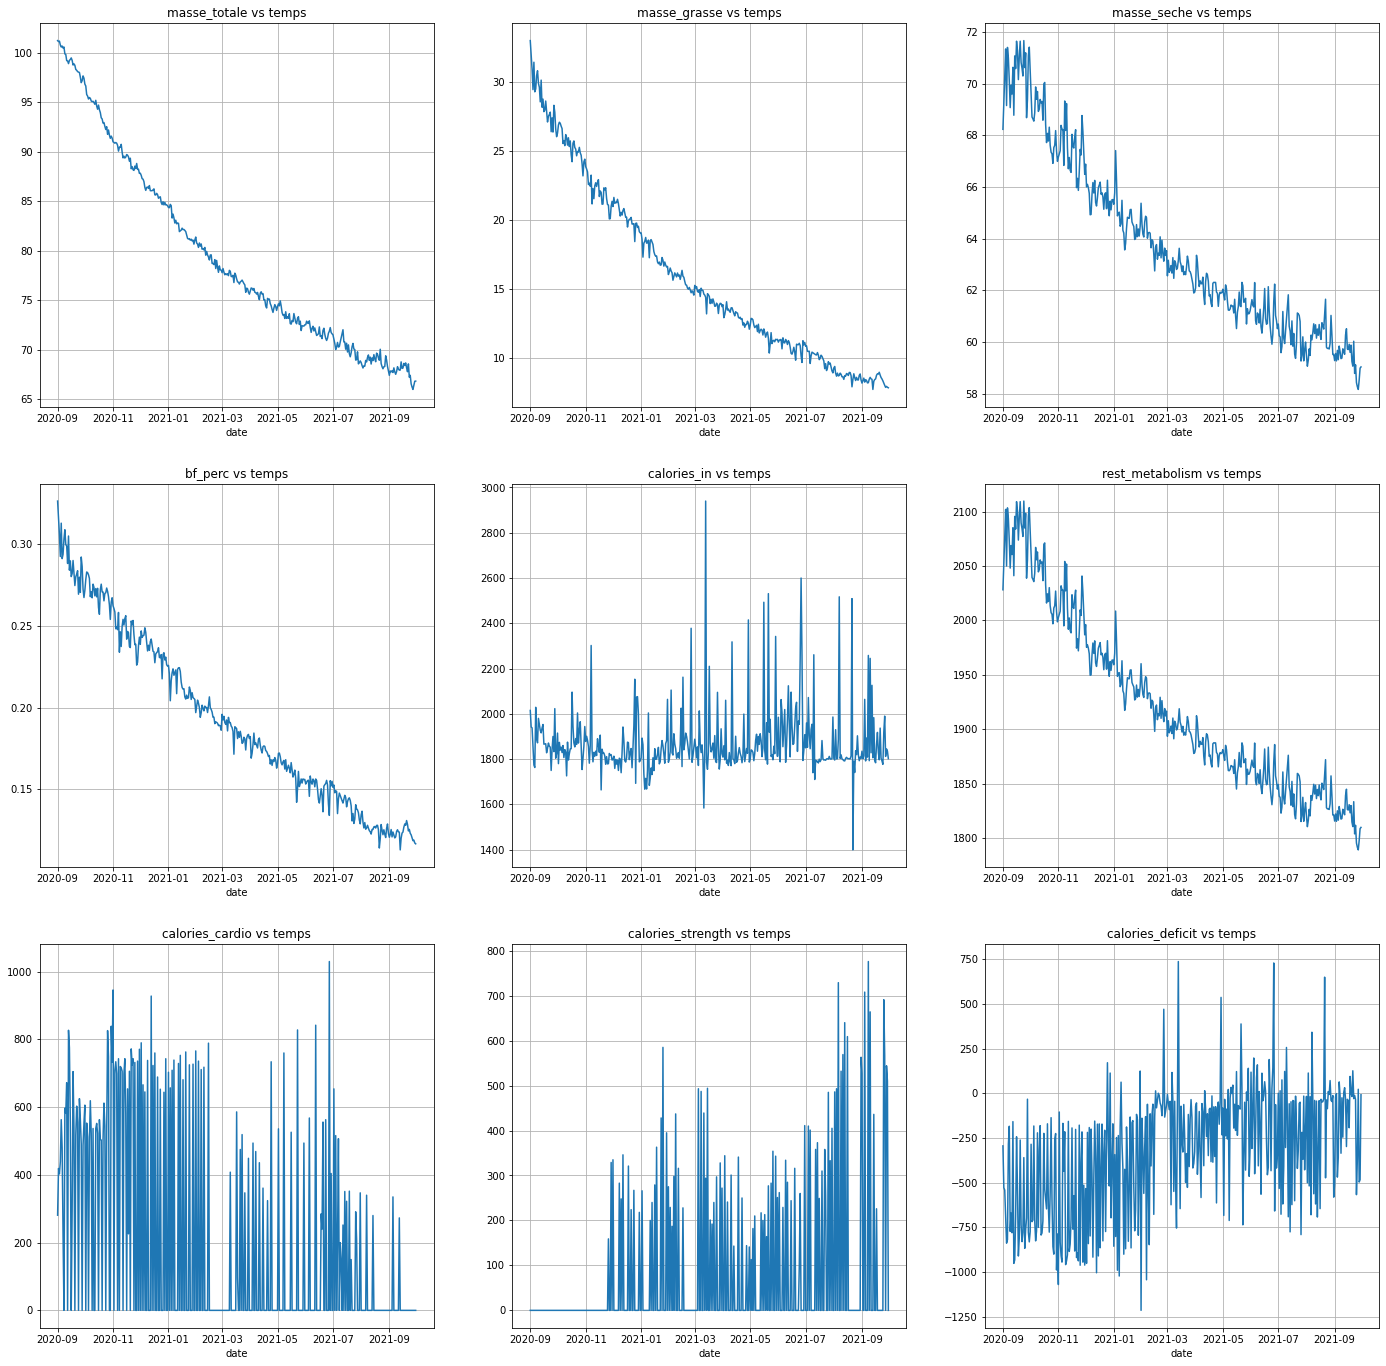

In [18]:
wl.plot_columns(df=df_seche)

In [19]:
df_bulk

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,...,sch,kma,base_metabolism,rest_metabolism,calories_deficit,moyenne calories_exercice,moyenne calories_deficit,moyenne masse_totale,moyenne masse_seche,moyenne bf_perc
date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,66.591667,7.896667,1799.0,119.0,61.0,191.0,0.0,0.0,0.0,58.695000,...,1637.039600,1637.812000,1637.812000,1801.593200,-2.593200,151.533333,-110.028435,68.079587,59.676655,0.123410
2021-10-02,66.792857,7.887143,1974.0,183.0,31.0,124.0,770.0,0.0,770.0,58.905714,...,1639.347657,1642.363429,1642.363429,1806.599771,-602.599771,151.533333,-109.353261,68.030513,59.645433,0.123235
2021-10-03,67.018000,7.900000,2378.0,143.0,52.0,189.0,0.0,0.0,0.0,59.118000,...,1641.930496,1646.948800,1646.948800,1811.643680,566.356320,168.644444,-121.670127,67.966651,59.604523,0.123014
2021-10-04,66.783333,7.541667,2095.0,153.0,74.0,200.0,744.0,0.0,744.0,59.241667,...,1639.238400,1649.620000,1649.620000,1814.582000,-463.582000,168.644444,-108.044289,67.910384,59.570701,0.122787
2021-10-05,66.583333,7.953333,1799.0,174.0,48.0,152.0,0.0,0.0,0.0,58.630000,...,1636.944000,1636.408000,1636.408000,1800.048800,-1.048800,185.177778,-117.668778,67.857125,59.542738,0.122508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17,68.665000,8.680000,2155.0,256.0,46.0,181.0,457.0,0.0,457.0,59.985000,...,1660.824880,1665.676000,1665.676000,1832.243600,-134.243600,339.822222,21.806283,67.873060,59.535837,0.122833
2021-12-18,68.030000,8.178000,2144.0,214.0,56.0,177.0,423.0,0.0,423.0,59.852000,...,1653.540160,1662.803200,1662.803200,1829.083520,-108.083520,337.600000,25.799808,67.909901,59.562298,0.122919
2021-12-19,68.750000,8.596000,1741.0,213.0,54.0,95.0,0.0,0.0,0.0,60.154000,...,1661.800000,1669.326400,1669.326400,1836.259040,-95.259040,347.000000,23.583585,67.916540,59.568592,0.122912


In [20]:
df_bulk.describe()

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,...,sch,kma,base_metabolism,rest_metabolism,calories_deficit,moyenne calories_exercice,moyenne calories_deficit,moyenne masse_totale,moyenne masse_seche,moyenne bf_perc
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,...,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,67.613106,8.218084,2137.939024,204.658537,56.939024,184.219512,308.487805,18.658537,289.829268,59.395022,...,1648.757555,1652.932477,1652.932477,1818.225725,11.225495,265.546612,-24.947234,67.504850,59.307475,0.121415
std,0.600843,0.267412,444.548025,69.278329,22.258497,30.587266,299.079049,84.227092,305.455693,0.435772,...,6.892873,9.412666,9.412666,10.353933,436.574574,49.794627,60.818250,0.249561,0.155012,0.000978
min,66.171429,7.541667,1741.000000,71.000000,22.000000,95.000000,0.000000,0.000000,0.000000,58.334286,...,1632.218629,1630.020571,1630.020571,1793.022629,-612.512400,151.533333,-136.018836,67.068398,59.043932,0.119606
25%,67.206771,8.027500,1812.250000,156.500000,44.000000,168.250000,0.000000,0.000000,0.000000,59.170500,...,1644.096075,1648.082800,1648.082800,1812.891080,-121.514280,225.222222,-68.130260,67.340433,59.209248,0.120802
50%,67.621591,8.210929,2099.500000,196.500000,54.500000,183.500000,317.500000,0.000000,290.500000,59.358125,...,1648.854891,1652.135500,1652.135500,1817.349050,-22.374400,282.077778,-5.049739,67.469385,59.278593,0.121372
75%,67.995000,8.428333,2289.000000,238.500000,62.000000,198.750000,554.750000,0.000000,547.750000,59.561250,...,1653.138640,1656.523000,1656.523000,1822.175300,10.666160,301.577778,23.164021,67.678541,59.406348,0.122170
max,69.455000,8.811250,4785.000000,511.000000,184.000000,264.000000,920.000000,647.000000,920.000000,60.705000,...,1669.887760,1681.228000,1681.228000,1849.350800,2471.170400,347.000000,69.621252,68.079587,59.676655,0.123410


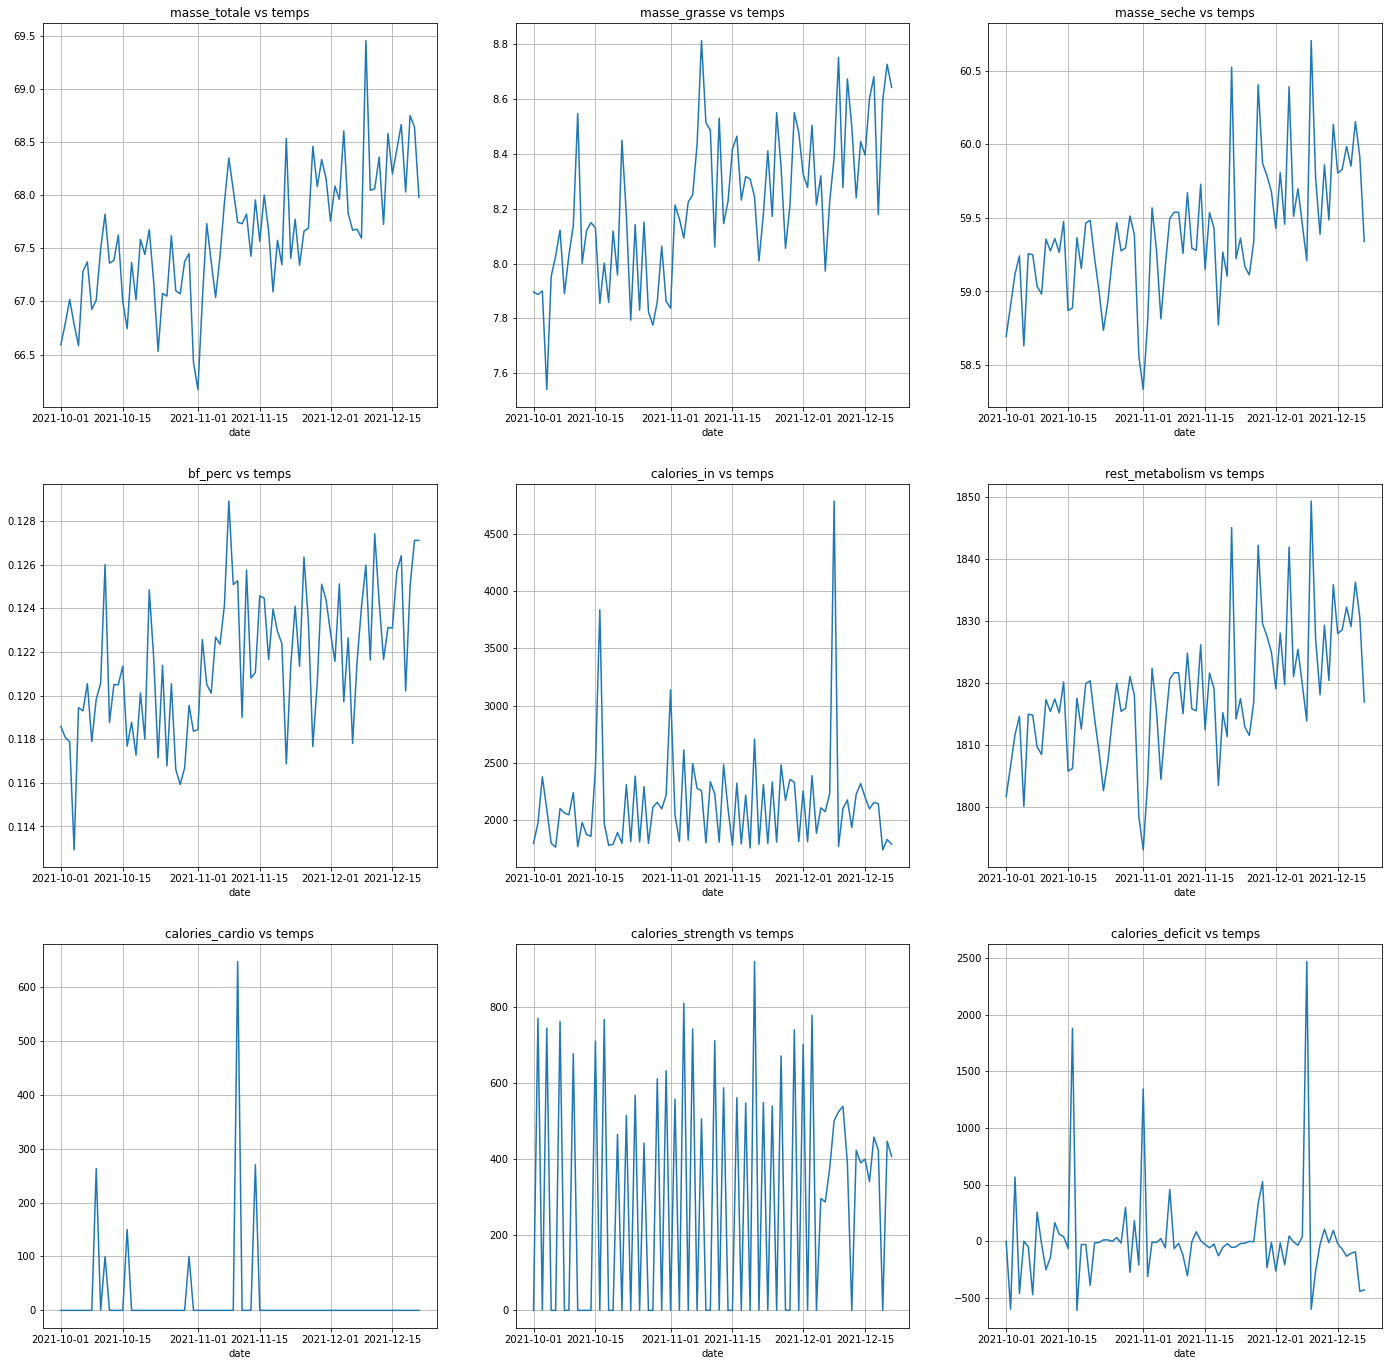

In [21]:
wl.plot_columns(df=df_bulk)

# Quelles dynamiques sur les deux périodes ?

rythme mensuel moyen sur la période de masse_totale = -2.476 avec coeff correlation = 95.0%
rythme mensuel moyen sur la période de masse_seche = -0.861 avec coeff correlation = 92.0%
rythme mensuel moyen sur la période de bf_perc = -0.014 avec coeff correlation = 97.0%


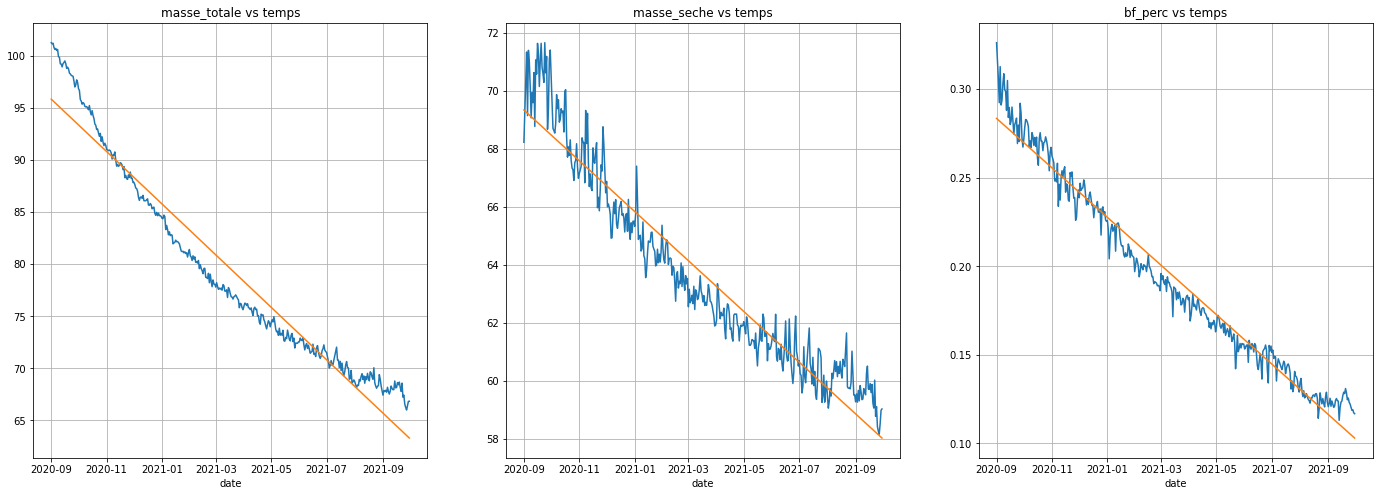

In [22]:
wl.plot_trends(df_seche)

rythme mensuel moyen sur la période de masse_totale = 0.55 avec coeff correlation = 53.0%
rythme mensuel moyen sur la période de masse_seche = 0.33 avec coeff correlation = 36.0%
rythme mensuel moyen sur la période de bf_perc = 0.002 avec coeff correlation = 31.0%


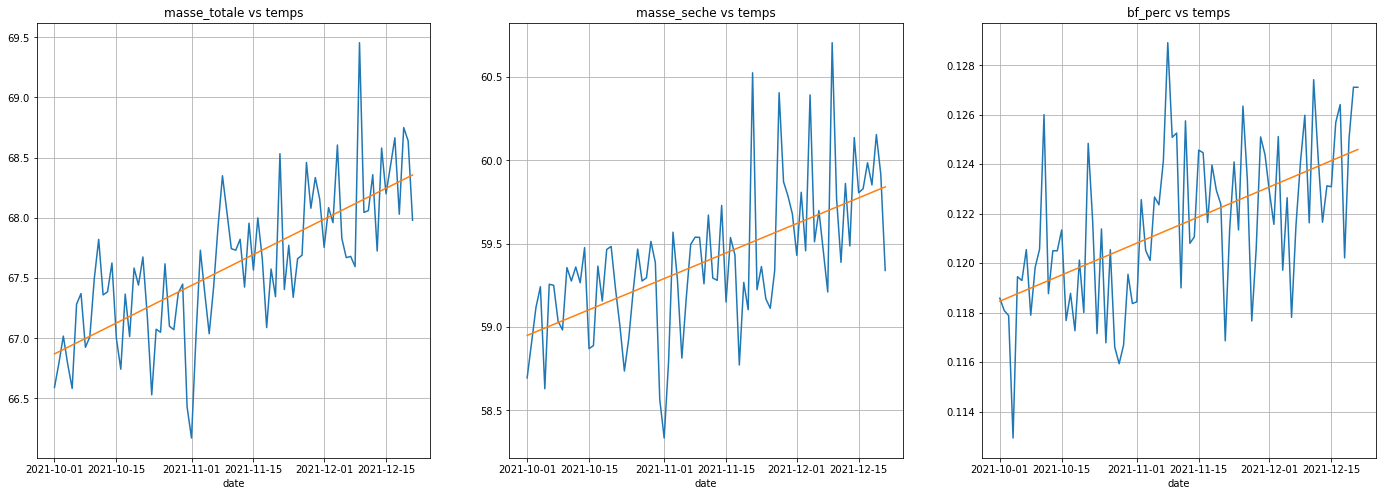

In [23]:
wl.plot_trends(df_bulk)

# Quelle(s) différence(s) principale(s) entre ces deux périodes ??

valeur médiane de calories_in pendant la période seche = 1831.0 kcals
valeur médiane de calories_in pendant la période bulk = 2100.0 kcals
---------------
valeur médiane de calories_nettes pendant la période seche = 1654.0 kcals
valeur médiane de calories_nettes pendant la période bulk = 1795.0 kcals
---------------
valeur médiane de rest_metabolism pendant la période seche = 1899.0 kcals
valeur médiane de rest_metabolism pendant la période bulk = 1817.0 kcals
---------------
valeur médiane de calories_deficit pendant la période seche = -245.0 kcals
valeur médiane de calories_deficit pendant la période bulk = -22.0 kcals
---------------


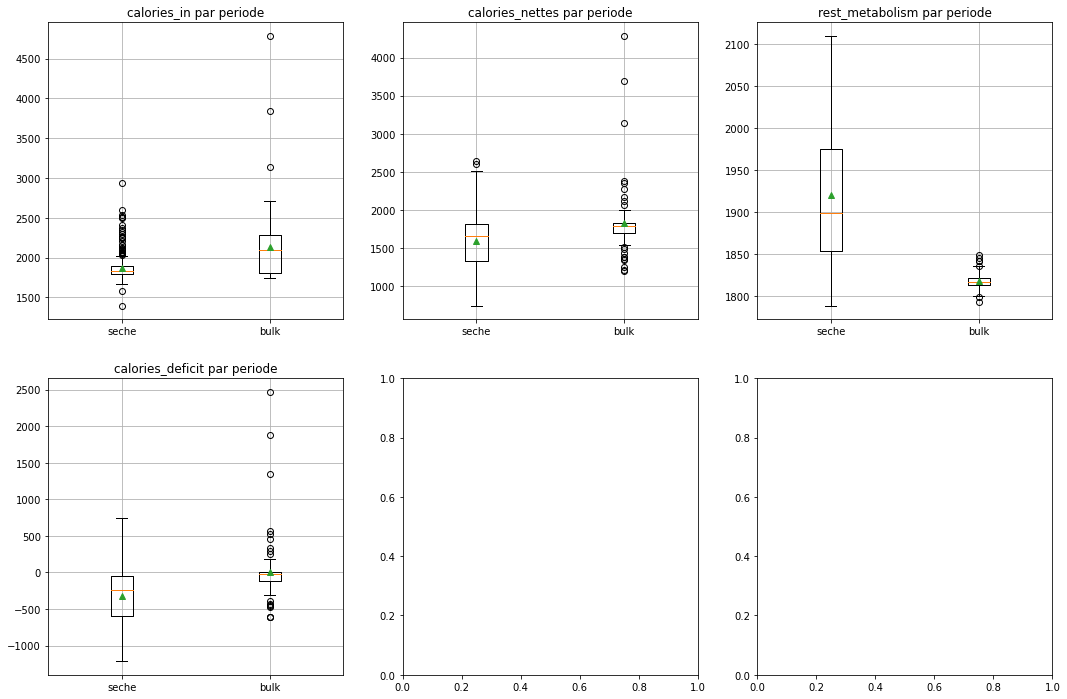

In [24]:
wl.plot_boxes(df_seche, df_bulk)

### En regardant les médianes seules des deux périodes (certes de longueur différente)
le déficit calorique se rapproche de 0 pour le bulk

### Première recherche sur Masse Totale

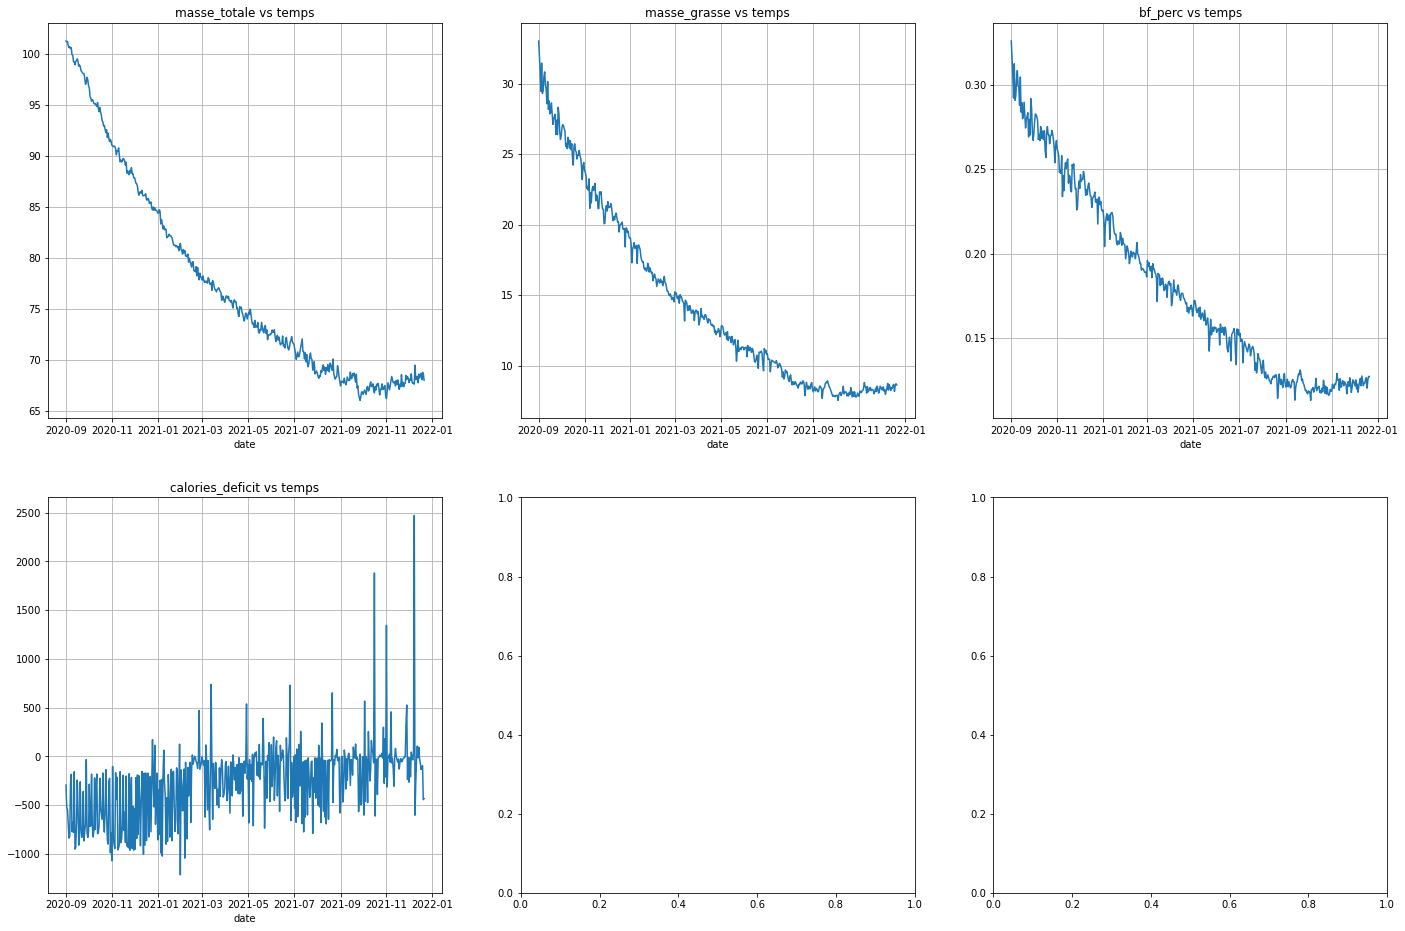

In [25]:
wl.plot_columns(df=df, columns_list=['masse_totale','masse_grasse','bf_perc','calories_deficit'])

In [26]:
df['log_mt'] = df['masse_totale'].apply(np.log)

In [27]:
cut_off = datetime.date(2021,10,1)

df_seche = df[df.index < cut_off]
df_bulk = df[df.index >= cut_off]

rythme mensuel moyen sur la période de masse_totale = -2.476 avec coeff correlation = 95.0%
rythme mensuel moyen sur la période de log_mt = -0.031 avec coeff correlation = 97.0%


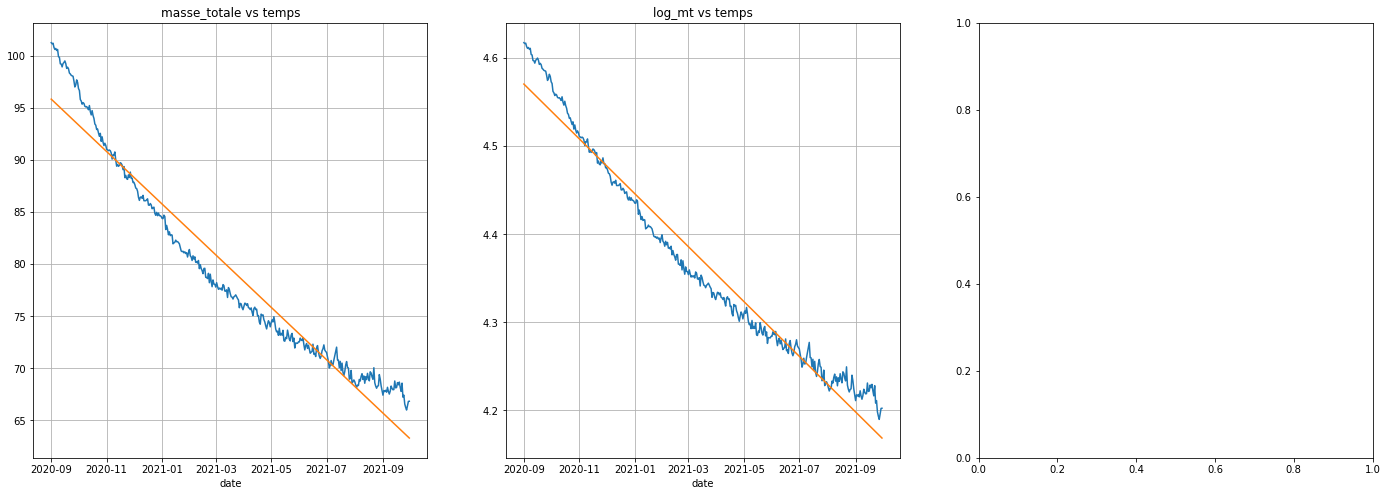

In [28]:
wl.plot_trends(df=df_seche, columns_list=['masse_totale', 'log_mt'])

rythme mensuel moyen sur la période de masse_totale = 0.55 avec coeff correlation = 53.0%
rythme mensuel moyen sur la période de log_mt = 0.008 avec coeff correlation = 53.0%


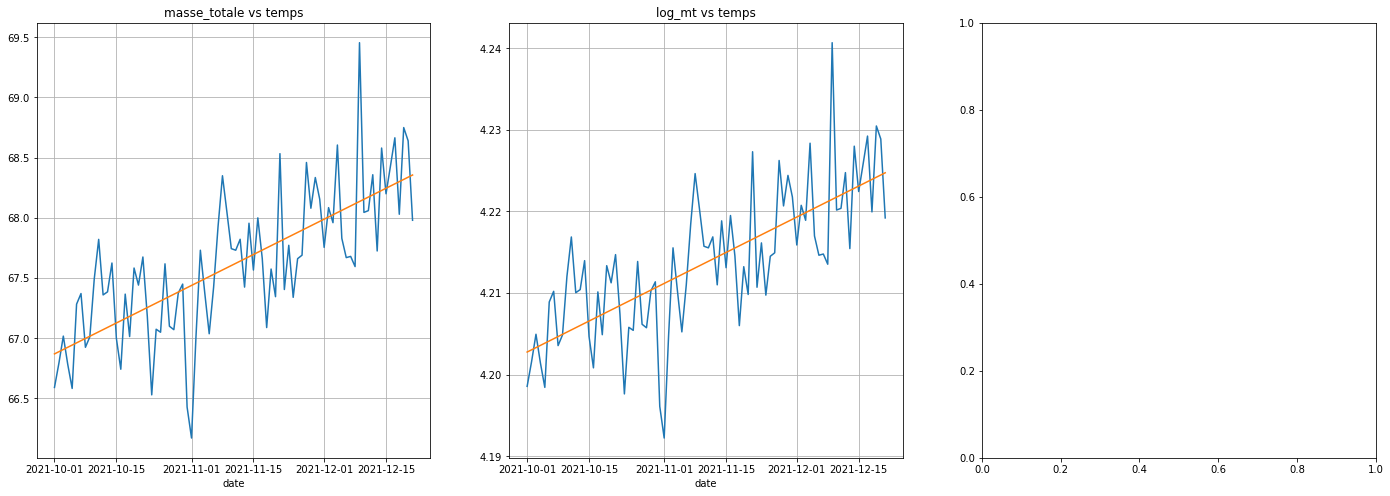

In [29]:
wl.plot_trends(df=df_bulk, columns_list=['masse_totale', 'log_mt'])

### Hypothèse 1 : corrélation entre la variation de masse totale et le déficit calorique, sur une période de temps à déterminer

In [30]:
df_test = df[['masse_totale', 'calories_deficit']]
df_test

,masse_totale,calories_deficit
date,,
2020-09-01,101.250,-294.14480
2020-09-02,101.150,-528.31080
2020-09-03,101.200,-541.61520
2020-09-04,100.800,-690.03840
2020-09-05,100.600,-839.00400
...,...,...
2021-12-17,68.665,-134.24360
2021-12-18,68.030,-108.08352
2021-12-19,68.750,-95.25904


In [31]:
window = 15

In [32]:
df_test['variation_masse_moyenne'] = df['masse_totale'].diff(1).rolling(window).mean()
df_test['deficit_moyen'] = df['calories_deficit'].rolling(window).mean().shift(1)

df_test = df_test[window:]

C:\Users\BENJAM~1.DEP\AppData\Local\Temp/ipykernel_11276/2261957549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['variation_masse_moyenne'] = df['masse_totale'].diff(1).rolling(window).mean()
C:\Users\BENJAM~1.DEP\AppData\Local\Temp/ipykernel_11276/2261957549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['deficit_moyen'] = df['calories_deficit'].rolling(window).mean().shift(1)


In [33]:
df_test.head(5)

# variation masse moyenne = (masse J - masse à J-window) / window
# deficit moyen = deficit calorique moyenné sur la window

,masse_totale,calories_deficit,variation_masse_moyenne,deficit_moyen
date,,,,
2020-09-16,99.500000,-243.1664,-0.116667,-608.978160
2020-09-17,99.250000,-526.6128,-0.126667,-605.579600
2020-09-18,98.783333,-910.8432,-0.161111,-605.466400
2020-09-19,98.900000,-807.7916,-0.126667,-630.081600
2020-09-20,98.750000,-261.1664,-0.123333,-637.931813


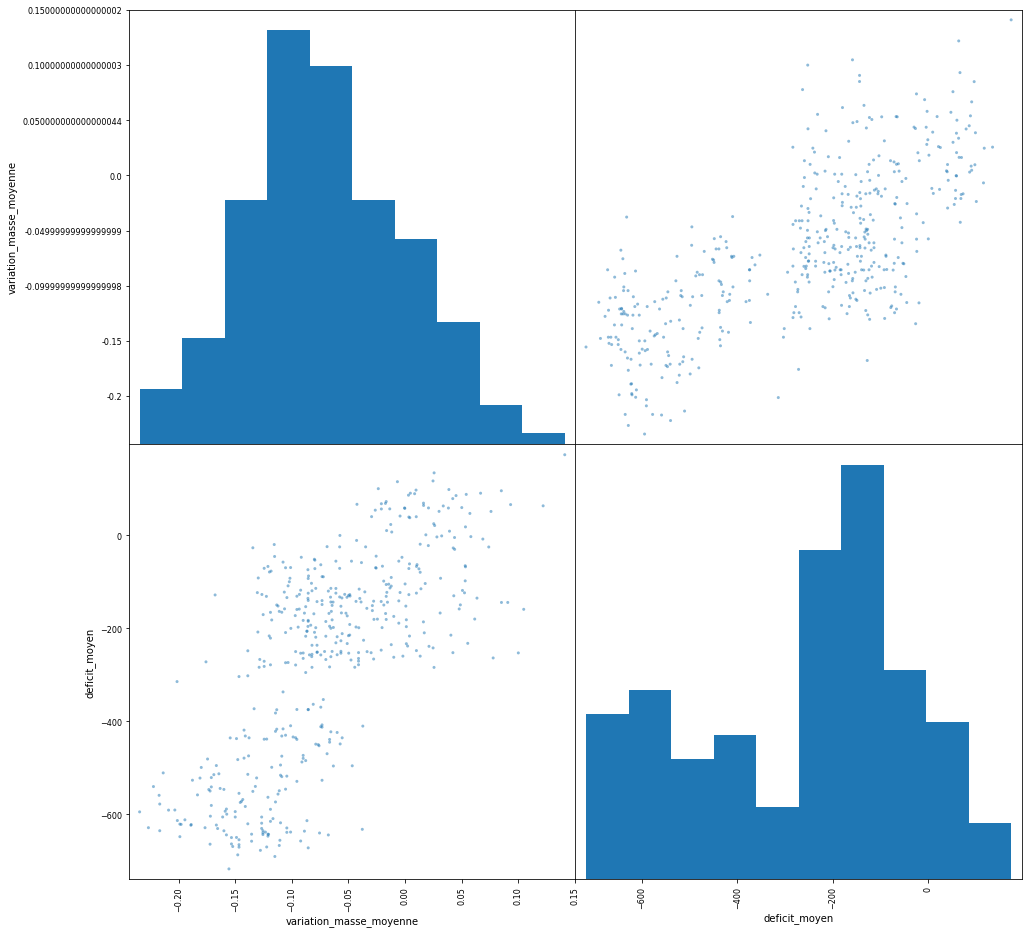

In [34]:
pd.plotting.scatter_matrix(df_test[['variation_masse_moyenne','deficit_moyen']], figsize=(16,16))
plt.show()

In [35]:
df_test.corr()

# NB : la moyenne de la variation journalière de poids corrèle mieux avec le déficit calorique que la variation brute

,masse_totale,calories_deficit,variation_masse_moyenne,deficit_moyen
masse_totale,1.000000,-0.516787,-0.696248,-0.892398
calories_deficit,-0.516787,1.000000,0.375044,0.506170
variation_masse_moyenne,-0.696248,0.375044,1.000000,0.714801
deficit_moyen,-0.892398,0.506170,0.714801,1.000000


On va tracer l'autocorrélation, pour savoir à quel ordre différencier pour stationnariser

In [36]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [37]:
def describe_order(df, name):
    
    fig, ax = plt.subplots(nrows=2,
                       ncols=2,
                       figsize=(12,12))
    
    df.plot(ax=ax[0,0], grid=True)
    ax[0,0].set_title(name)
    
    df.plot.hist(ax=ax[0,1], grid=True)
    ax[0,1].set_title(name)
    
    plot_acf(df, ax=ax[1,0])
    plot_pacf(df, ax=ax[1,1], method='ywm')
    
    plt.show()

Ordre 0

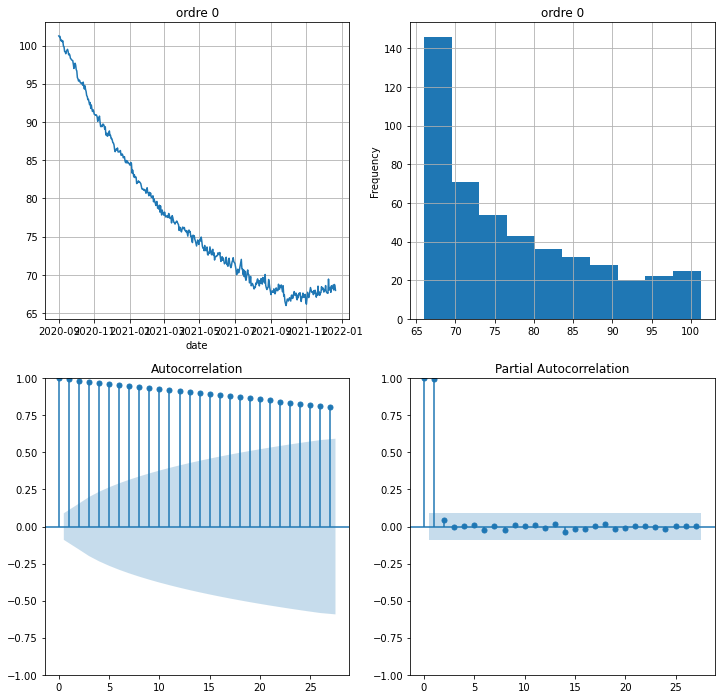

In [38]:
d0_mt = df['masse_totale']

describe_order(d0_mt, 'ordre 0')

Ordre 1

In [39]:
d1_mt = d0_mt.diff()[1:]

d1_mt.describe()

count    476.000000
mean      -0.069895
std        0.441452
min       -1.440000
25%       -0.366667
50%       -0.091250
75%        0.230833
max        1.859545
Name: masse_totale, dtype: float64

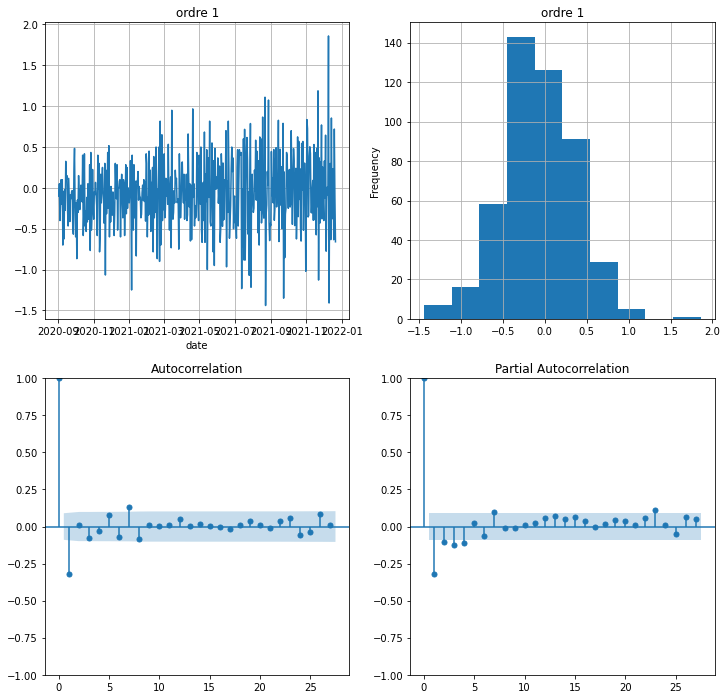

In [40]:
describe_order(d1_mt, 'ordre 1')

Ordre 2

In [41]:
d2_mt = d1_mt.diff()[1:]
d2_mt.describe()

count    475.000000
mean      -0.001179
std        0.716820
min       -3.269091
25%       -0.442500
50%        0.016667
75%        0.472500
max        1.944091
Name: masse_totale, dtype: float64

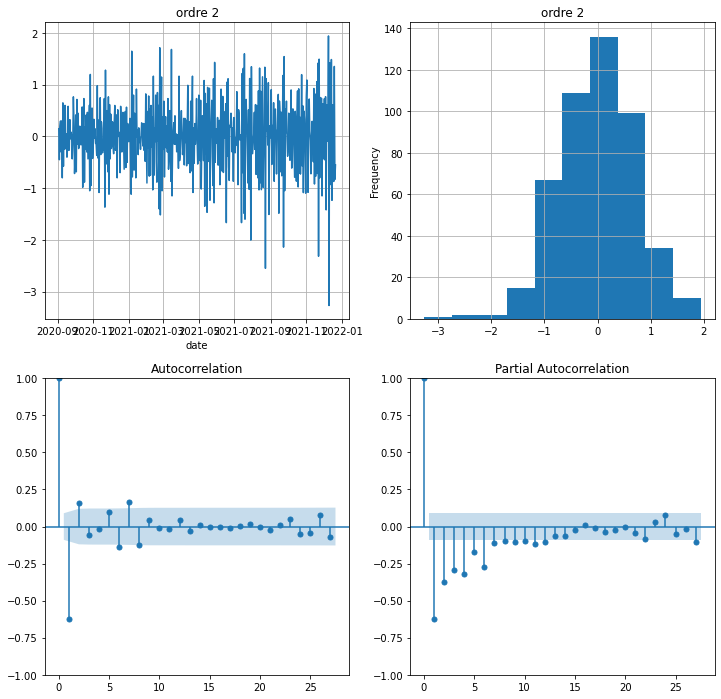

In [42]:
describe_order(d2_mt, 'ordre 2')

Ordre 3...

In [43]:
d3_mt = d2_mt.diff()[1:]
d3_mt.describe()

count    474.000000
mean      -0.001477
std        1.292845
min       -5.213182
25%       -0.816667
50%        0.072024
75%        0.866667
max        4.693182
Name: masse_totale, dtype: float64

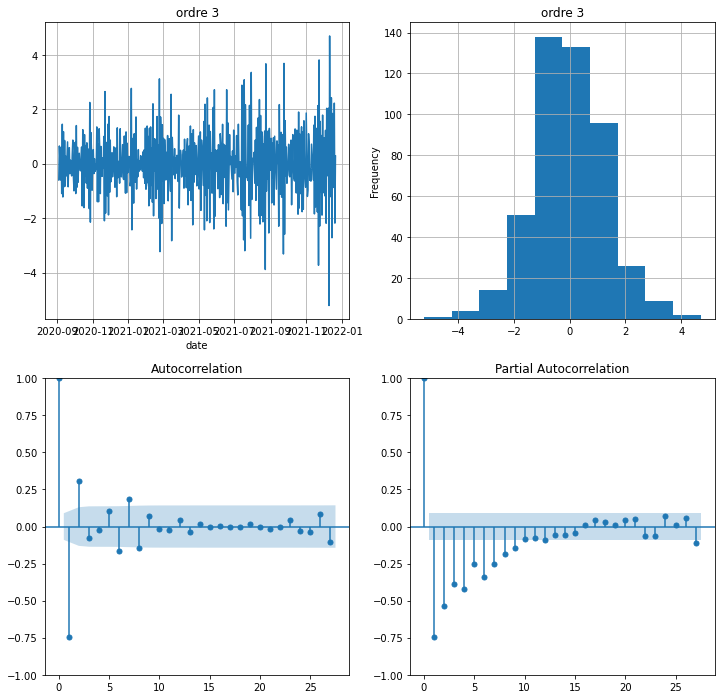

In [44]:
describe_order(d3_mt, name='ordre 3')

Ordre 4

In [45]:
d4_mt = d3_mt.diff()[1:]
d3_mt.describe()

count    474.000000
mean      -0.001477
std        1.292845
min       -5.213182
25%       -0.816667
50%        0.072024
75%        0.866667
max        4.693182
Name: masse_totale, dtype: float64

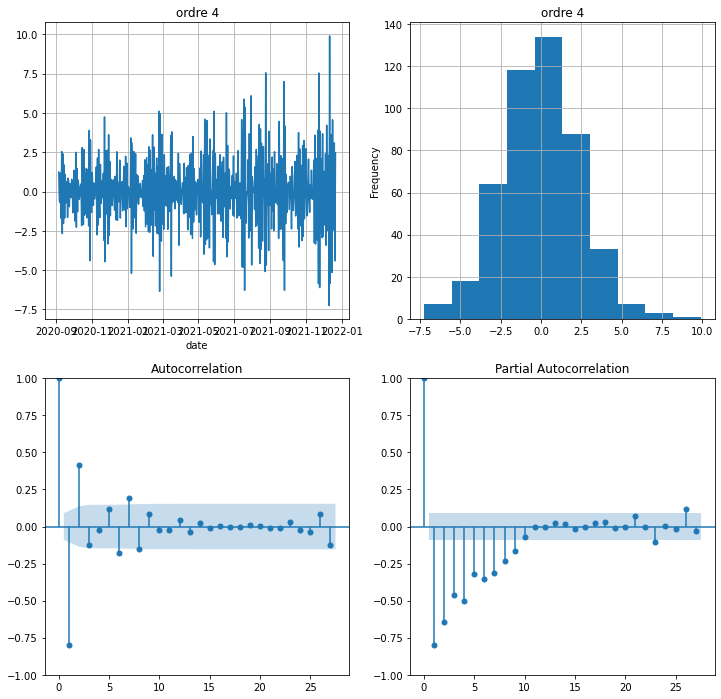

In [46]:
describe_order(d4_mt, name='ordre 4')